# 素数判定あれこれ

In [1]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sympy import *
from tqdm import tqdm_notebook as tqdm
from decimal import *
getcontext()
from functools import reduce

## 素朴な素数判定

In [15]:
def is_prime(num):
    for k in range(2, int(math.sqrt(num))+1):
        if num%k == 0:
            return False
            break
    else: return True

In [17]:
is_prime(4)

False

In [ ]:
%timeit is_prime(2**31-1)

In [ ]:
N=20
nlist = [(i,is_prime(i)) for i in range(2,N)]
print(nlist)

## 素数の個数

In [3]:
Num = 3000
checklist = [(k, is_prime(k)) for k in range(2, Num+1)]

plist = [n[0] for n in checklist if n[1]] #= list(filter(lambda x: x[1], checklist))
print("There are {} prime numbers up to {}".format(len(plist), Num))

There are 454 prime numbers up to 3000


## 素数定理

In [68]:
Num = 10000*3
plist = [k for k in range(2, Num+1) if is_prime(k)]
#print(plist)

In [71]:
bp_n = range(5,Num+1)
'''
bp_p = []
for n in bp_n:
#    n までの素数の個数を勘定して、bp_p に加える。
    plist = [i for i in range(2, n+1) if is_prime(i)]
    bp_p.append(len(plist))
'''
bp_p = []
for n in bp_n:
    kosuu = len([p for p in plist if p <= n])
    bp_p.append(kosuu)

bp_y = [x/(math.log(x)-1.1*0) for x in bp_n]

#print(bp_p)

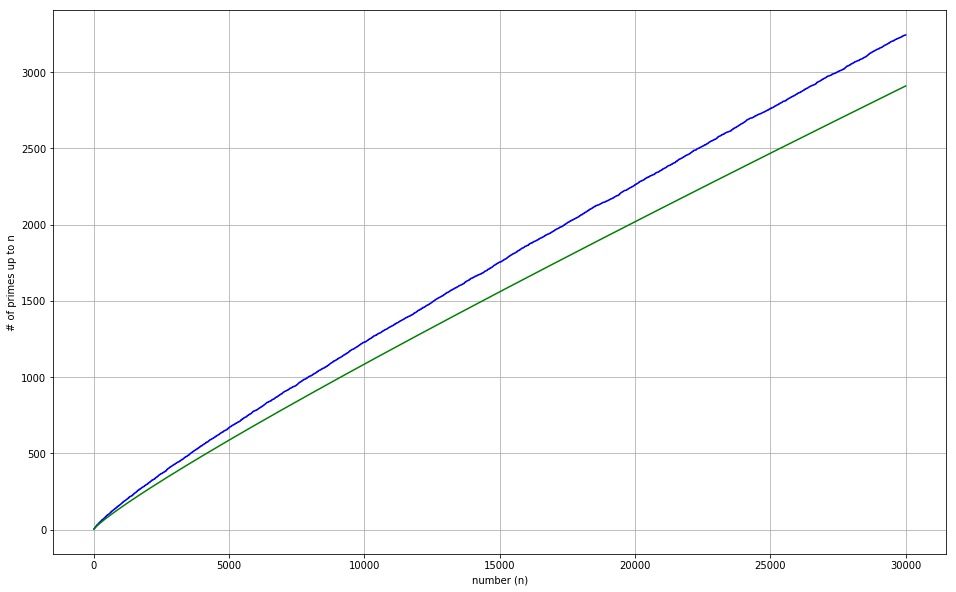

In [72]:
# Make the plot
plt.figure(figsize=(16,10))

ax = plt.subplot()
ax.grid()
ax.set(xlabel='number (n)', ylabel='# of primes up to n')

plt.plot(bp_n, bp_p, color='blue')
plt.plot(bp_n, bp_y, color='green')
plt.show()

# 素数判定の高速化

In [ ]:
%%timeit
Num = 10**5
checklist = [(k, is_prime(k)) for k in range(2, Num+1)]

plist = [n[0] for n in checklist if n[1]] #= list(filter(lambda x: x[1], checklist))
print("There are {} prime numbers up to {}".format(len(plist), Num))

In [ ]:
Num = 10**4
%timeit nlist=[k for k in range(2,Num+1) if k%3 == 0]
%timeit num = 5; nlist = [num*k for k in range(1,int(Num/num)+1)]

In [ ]:
def find_factor_01(num):
    mx = int(math.sqrt(num))    
    count = 0
    for k in range(2, mx+1):
        count += 1
        if num%k==0: print(k)
            
def find_factor_02(num):
    mx = int(math.sqrt(num))
    composites = []
    for k in range(2, mx+1):
        if k not in composites:
            if num%k==0: print(k)
            else: composites.extend([k*i for i in range(2, int(mx/k)+1)])
                
def find_factor_03(num):
    nlist = list(range(2, int(math.sqrt(num))+1))
    while nlist:
        mm = nlist.pop(0)
        res = num%mm
        if res == 0:
            print(mm)
            break
        else:
            nlist = [k for k in nlist if k%mm > 0]

In [ ]:
%load_ext line_profiler

In [ ]:
num = 2**31-1
%lprun -f find_factor_02 find_factor_02(num)

```
Timer unit: 1e-06 s

Total time: 16.8452 s
File: <ipython-input-6-02803966a958>
Function: find_factor_02 at line 8

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     8                                           def find_factor_02(num):
     9         1          8.0      8.0      0.0      mx = int(math.sqrt(num))
    10         1          2.0      2.0      0.0      composites = []
    11     46340      38539.0      0.8      0.2      for k in range(2, mx+1):
    12     46339   16744590.0    361.3     99.4          if k not in composites:
    13      4792       8903.0      1.9      0.1              if num%k==0: print(k)
    14      4792      53194.0     11.1      0.3              else: composites.extend([k*i for i in range(2, int(mx/k)+1)])
```

# 素因数分解

再帰的処理で素因数分解を実装

In [ ]:
def find_a_factor(num):
    num = abs(int(num))
    for n in range(2,int(math.sqrt(num))+1):
        if num%n==0: return n; break
    else: return num
        
def factorisation(num, facs_list=None):
    if facs_list is None: facs_list = []
    facs_list.append(find_a_factor(num))
    if facs_list[-1]!=num:
        facs_list=factorisation(int(num/facs_list[-1]), facs_list)
    return facs_list

In [ ]:
p = 53
mp = 2**p-1

if is_prime(p): msg = "PRIME"
else: msg = "COMPOSIT"
    
print("{} is a {}".format(p, msg))

fact_str = '*'.join(map(str,factorisation(mp)))
print("2**{}-1={} is factorised to {}.".format(p,mp,fact_str))